In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install tensorflow==1.14
import tensorflow as tf
print("Version: ", tf.__version__)

# Preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Embedding, Dropout
from tensorflow.keras.models import Sequential

# Loading
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras import layers
from tensorflow import keras

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

os.chdir("../")

C:\Users\quort\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\quort\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\quort\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\quort\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Version:  1.14.0


In [2]:
%pwd

'C:\\Users\\quort\\Documents\\GitHub\\affinity\\backend'

In [3]:
df = pd.read_csv(r"C:\Users\quort\Documents\GitHub\affinity\backend\data\augmented_data.csv")
df.head()


,Body,Bias
0,Abortion rights advocates have asked the U.S. ...,1.67
1,"The court in February, by a 5-4 vote, temporar...",1.67
2,The organization is challenging a decision by ...,1.67
3,“The stakes in this case are high for the rule...,1.67
4,The group says enforcement of the law would im...,1.67


## DATA 

In [4]:
df.loc[df['Bias'] <= 0, 'Bias'] = 0
df.loc[df['Bias'] > 0, 'Bias'] = 1

In [5]:
#df = df.drop(columns=['Body'])

In [6]:
train_set, testval_set = train_test_split(df)
val_set, test_set = train_test_split(testval_set, train_size=0.5)

#X_train = train_set['cleaned_body']
#X_val = val_set['cleaned_body']
#X_test = test_set['cleaned_body']

X_train = train_set['Body']
X_val = val_set['Body']
X_test = test_set['Body']

y_train = train_set['Bias'].values
y_val = val_set['Bias'].values
y_test = test_set['Bias'].values

In [7]:
# Tokenizing
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [8]:
# Padding sequences
#X_train_pad = pad_sequences(sequences_train)

#MAX_LEN = X_train_pad.shape[1]
MAX_LEN = 2000

X_train_pad = pad_sequences(sequences_train, maxlen=MAX_LEN)
X_val_pad = pad_sequences(sequences_val, maxlen=MAX_LEN)
X_test_pad = pad_sequences(sequences_test, maxlen=MAX_LEN)

print('Training shape: ', X_train_pad.shape)
print('Validation shape: ', X_val_pad.shape)
print('Testing shape: ', X_test_pad.shape)

Training shape:  (25280, 2000)
Validation shape:  (4213, 2000)
Testing shape:  (4214, 2000)


In [9]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by the batch size
    """

    no_of_rows_drop = mat.shape[0] % batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [11]:
testdataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [12]:
X_train.shape

(25280,)

In [13]:
X_val.shape

(4213,)

In [16]:
V = len(tokenizer.word_index) # Corpus length
D = min(600, round(1.6 * V ** .56)) # Dimensionality of Embedding layer

###############################################################################
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)
###############################################################################

In [25]:
model = tf.keras.Sequential()

model.add(Input(shape=(X_train_pad.shape[1],)))
model.add(Embedding(V + 1, D))
model.add(layers.Conv1D(64, 3, activation = "relu"))
model.add(layers.MaxPooling1D(4))
model.add(layers.Conv1D(32, 3, activation = "relu"))

model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 600)         25612800  
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1998, 64)          115264    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 499, 64)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 497, 32)           6176      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 25,734,273
Trainable params: 25,734,273
Non-trainable params: 0
__________________________________________

In [26]:
V

42687

In [27]:
D

600

In [28]:
EPOCHS = 3
BATCH_SIZE = 128

X_train_pad = trim_dataset(X_train_pad, BATCH_SIZE)
y_train = trim_dataset(y_train, BATCH_SIZE)
#X_val_pad = trim_dataset(X_val_pad, BATCH_SIZE)
#y_val = trim_dataset(y_val, BATCH_SIZE)

print('Training...')
r = model.fit(X_train_pad, 
              y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE,
              validation_data=(X_val_pad, y_val))

Training...
Train on 25216 samples, validate on 4213 samples
Epoch 1/3
25216/25216 [==============================] - 359s 14ms/sample - loss: 0.5940 - acc: 0.6963 - val_loss: 0.5397 - val_acc: 0.7304
Epoch 2/3
25216/25216 [==============================] - 314s 12ms/sample - loss: 0.4163 - acc: 0.8087 - val_loss: 0.5128 - val_acc: 0.7555
Epoch 3/3
25216/25216 [==============================] - 334s 13ms/sample - loss: 0.2150 - acc: 0.9177 - val_loss: 0.6285 - val_acc: 0.7584


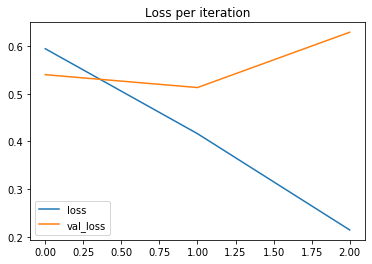

In [29]:
plt.title('Loss per iteration')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

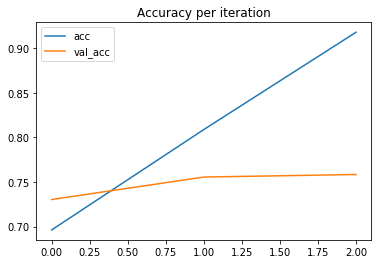

In [36]:
plt.title('Accuracy per iteration')
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()

In [32]:
model.evaluate(X_test, y_test)

ValueError: Error when checking input: expected input_4 to have shape (2000,) but got array with shape (1,)

In [33]:
y_pred = model.predict_classes(X_test)
y_pred = [i for sublist in y_pred for i in sublist]

ValueError: Error when checking input: expected input_4 to have shape (2000,) but got array with shape (1,)

In [34]:
roc_auc_score(y_test, y_pred)

NameError: name 'y_pred' is not defined

In [35]:
results = pd.DataFrame({"BATCH_SIZE: ":[BATCH_SIZE],
                        "LAYERS: ":[LAYER_NUM],
                        "EPOCHS: ":[EPOCHS],
                        "TRAINING SIZE: ":[X_train_pad.shape[0]],
                        "ACCURACY: ":[model_eval[1]],
                        "ROC: ":[roc_results]})
results

NameError: name 'LAYER_NUM' is not defined

In [ ]:
if not os.path.exists("models/cnn_results.csv"):
  results.to_csv("models/cnn_results.csv") 
else:
  results.to_csv("models/cnn_results.csv", header=False, mode='a')

In [ ]:
model_name = 'models/cnn_{layer_num}_{batch_size}_{epochs}_{training_size}'.format(layer_num=LAYER_NUM,
                                                                                     batch_size=BATCH_SIZE,
                                                                                     epochs=EPOCHS,
                                                                                     training_size=X_train_pad.shape[0])

#model.save(model_name + ".h5")

# serialize model to JSON
model_json = model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(model_name + ".h5")

print("Saved model to disk")